In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import librosa
import matplotlib.pyplot as plt
import csv, glob, math, copy, itertools, random
import seaborn as sns
from sklearn import svm 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn import cross_validation
from sklearn import datasets 
from sklearn import metrics
from sklearn.preprocessing import normalize

#from spectral_centroid import spectral_centroid

/usr/local/lib/python2.7/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def spectral_centroid(D, fft_freqs):
    D = np.abs(D) # Strip complex part and take magnitudes
    # Find peak amplitude
    mag_sums = np.sum(D,0)
    peak_mag = mag_sums.max()
    scs = []
    for t in range(np.shape(D)[1]):
        D_at_t = D[:, t]
        spectral_sum = np.sum(D_at_t)
        if(spectral_sum < 1.0):             # Don't let denominator drop < 1 to avoid blow-up
            spectral_sum = 1.0
         
        # "Silence" in these signals doesn't have the same HF noise issues as 
        # audio recording, and we're dealing with lower frequencies in general,
        # so this check doesn't make sense here.
        #if(mag_sums[t] < peak_mag * 0.05):  # If the magnitude is < 5% of peak
        #    scs.append(0.0)                 # don't calculate centroid
            
        else:
            scs.append(np.sum(fft_freqs * D_at_t) / spectral_sum)

    return(scs)

In [4]:
# Path to PACO here
base_path = '/Users/beau/Desktop/Projects/Universal Contours/Analysis - Frequency Spectrum/movement analysis/PACO point light ptd/'

<img src="PACO_JointIndex.jpg">

In [5]:
ptd_dirs = glob.glob(base_path + "*_pt")
paco_sampling_rate = 60.0    # The PACO Body Movement Library is sampled at 60 Hz

In [6]:
angry_paths = []
sad_paths = []

for d in ptd_dirs:
    dir_angry_paths = glob.glob(d + "/*walk_an*.ptd")
    angry_paths += dir_angry_paths
    dir_sad_paths = glob.glob(d + "/*walk_sa*.ptd")
    sad_paths += dir_sad_paths

In [7]:
# Z-scoring the data and using all three axes per joint

def paco_to_joints(path):
    """
    Split a file into time-series by joint. Each joint is an array of time-series arrays,
    where index 0, is x, 1 is y, and 2 is z.
    """
    joint_start_indexes = range(0,45,3)
    joints = []
    for i in joint_start_indexes:
        joints.append([[],[],[]])         # Start with an array of empty joint arrays
    
    with open(path, 'r') as ptd_file:
        reader = csv.reader(ptd_file, delimiter=' ')
        for n, row in enumerate(reader):
            if n > 0:    # First row is not a joint
                for joint_number, row_index in enumerate(joint_start_indexes):
                    joints[joint_number][0].append(float(row[row_index]))
                    joints[joint_number][1].append(float(row[row_index + 1]))
                    joints[joint_number][2].append(float(row[row_index + 2]))
    
    return(joints)

In [8]:
def joints_to_scs(joints, nfft=256, overlap=128):
    """
    Given an array of joint arrays (like from paco_to_joints()), convert all of the 
    joint time series to spectrograms and spectral centroid time series.
    """
    spectrograms = []
    scs = []
    for i in range(len(joints)):
        spectrograms.append([[],[],[]])
        scs.append([[],[],[]])
    
    # Iterate over joints and axes
    for i in range(len(joints)):
        for j in range(len(joints[i])):
            spectrogram = plt.specgram(joints[i][j], NFFT=nfft, noverlap=overlap, Fs=paco_sampling_rate)
            spectrograms[i][j] = spectrogram
            sc = spectral_centroid(spectrogram[0], spectrogram[1])
            scs[i][j] = sc
    
    return(scs, spectrograms)

In [9]:
def mean_subject_scs(subjects_sc_list):
    """
    Take a list of lists of subject lists of spectral info and return a list of 
    subject SC means for each joint and axis.
    """
    subjects_sc_means = []
    
    for subject in subjects_sc_list:
        joints = subject[0]
        joint_list = []
        for joint in joints:
            axis_means = []
            for axis_index, axis in enumerate(joint):
                axis_mean = np.mean(axis)
                axis_means.append(axis_mean)
            joint_list.append(axis_means)
        subjects_sc_means.append(joint_list)
    
    return(subjects_sc_means)

In [10]:
angry_subjects = map(paco_to_joints, angry_paths)
sad_subjects = map(paco_to_joints, sad_paths)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


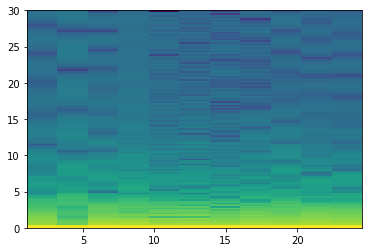

In [11]:
angry_spec_info = map(joints_to_scs, angry_subjects);
sad_spec_info = map(joints_to_scs, sad_subjects);

In [12]:
angry_mean_scs = mean_subject_scs(angry_spec_info)
sad_mean_scs = mean_subject_scs(sad_spec_info)

In [14]:
def select_mean_scs_for_joint_index(mean_scs, joint_index):
    output = []
    for subject in mean_scs:
        output.append(subject[joint_index])
    return(output)

In [15]:
def classify_3d_joint_index(all_joints_a, all_joints_b, joint_index, cv_val=10):
    selected_joints_a = select_mean_scs_for_joint_index(all_joints_a, joint_index)
    selected_joints_b = select_mean_scs_for_joint_index(all_joints_b, joint_index)
    return(classify_3d(selected_joints_a, selected_joints_b, cv_val))
    
def classify_3d(mean_scs_a, mean_scs_b, cv_val=2, permutation_test=False):
    clf = LDA() 
    X = np.array(mean_scs_a + mean_scs_b)
    y = ["A"] * len(mean_scs_a) + ["B"] * len(mean_scs_b)
    if(permutation_test):
        random.shuffle(y)
    scores = cross_validation.cross_val_score(clf, X, y, cv=cv_val)
    return((scores.mean(), scores.std()))

classify_3d_angry_sad = lambda i: classify_3d_joint_index(angry_mean_scs, sad_mean_scs, i)
classify_3d_happy_neutral = lambda i: classify_3d_joint_index(happy_mean_scs, neutral_mean_scs, i)
classify_3d_happy_angry = lambda i: classify_3d_joint_index(happy_mean_scs, angry_mean_scs, i)

In [16]:
angry_sad_classification_results = map(classify_3d_angry_sad, range(0, 15))

In [17]:
# Classification results per joint, using each axis as a feature
angry_sad_classification_results

[(0.85833333333333317, 0.098952850725315969),
 (0.84999999999999998, 0.10408329997330663),
 (0.89166666666666683, 0.098952850725315969),
 (0.89166666666666661, 0.09166666666666666),
 (0.91666666666666674, 0.091287092917527679),
 (0.875, 0.1070436048222094),
 (0.88333333333333319, 0.10000000000000001),
 (0.88333333333333341, 0.09279607271383368),
 (0.86666666666666659, 0.10671873729054748),
 (0.88333333333333319, 0.092796072713833694),
 (0.89166666666666661, 0.09166666666666666),
 (0.93333333333333335, 0.081649658092772595),
 (0.87499999999999978, 0.10704360482220941),
 (0.88333333333333341, 0.10671873729054748),
 (0.92500000000000004, 0.078616509433805035)]

In [18]:
angry_sad_joints_np = np.asarray(angry_sad_classification_results)
max(angry_sad_joints_np[:,0])

0.93333333333333335

In [19]:
min(angry_sad_joints_np[:,0])

0.84999999999999998

In [20]:
np.mean(angry_sad_joints_np, axis=0)

array([ 0.88722222,  0.09666616])

In [21]:
np.sum(np.array(angry_sad_classification_results)[:,0] > .875) / float(len(angry_sad_classification_results))

0.66666666666666663

In [22]:
# Flattens each of the subjects, so each joint-axis is a feature.

def classify_whole_body(all_joints_a, all_joints_b, cv_val=5, permutation_test=False):
    flatten_subject = lambda i, subject_list: list(itertools.chain(*subject_list[i]))
    flatten_a = lambda i: flatten_subject(i, all_joints_a)
    flatten_b = lambda i: flatten_subject(i, all_joints_b)
    
    flattened_a = map(flatten_a, range(0, len(all_joints_a)))
    flattened_b = map(flatten_b, range(0, len(all_joints_b)))

    return(classify_3d(flattened_a, flattened_b, cv_val, permutation_test))

# Now just to make sure I didn't mess that up...
def classify_whole_body_simple(all_joints_a, all_joints_b, cv_val=5, permutation_test=False):
    all_joints_a_flat = copy.deepcopy(all_joints_a)
    for i in range(len(all_joints_a_flat)):
        all_joints_a_flat[i] = list(itertools.chain(*all_joints_a_flat[i]))
        
    all_joints_b_flat = copy.deepcopy(all_joints_b)
    for i in range(len(all_joints_b_flat)):
        all_joints_b_flat[i] = list(itertools.chain(*all_joints_b_flat[i]))
        
    return(classify_3d(all_joints_a_flat, all_joints_b_flat, cv_val, permutation_test))

In [23]:
angry_sad_whole_body = classify_whole_body(angry_mean_scs, sad_mean_scs)
angry_sad_whole_body

(0.78333333333333333, 0.061237243569579478)

In [24]:
angry_mean_scs[0:2]

[[[0.15122988855753078, 0.16808422510592266, 0.07886782120231417],
  [0.150425312366914, 0.1669883725728821, 0.078837832524800908],
  [0.14965719407885039, 0.1688722355878913, 0.078874374726849356],
  [0.15182118813546575, 0.17408592685154592, 0.078755686005733072],
  [0.17434543351480053, 0.22550626633157514, 0.084268962015616608],
  [0.15228567436437684, 0.16782471304439406, 0.07885247846054827],
  [0.15203194521804803, 0.16903491156291323, 0.078969145159986209],
  [0.16573132412220007, 0.18307840680961235, 0.084299427362055715],
  [0.15059455737696706, 0.16899120845583604, 0.079073280589517431],
  [0.15013710061648325, 0.17048418729369358, 0.079073959377055858],
  [0.15904183634246569, 0.1860793166320624, 0.080469055616881738],
  [0.16835722738254041, 0.19773759337363689, 0.16347928513511142],
  [0.15191281841504048, 0.16945595437548158, 0.079106180281155042],
  [0.16341708555449916, 0.18487436697294771, 0.081746513709654661],
  [0.169494200596292, 0.19521674796093286, 0.17390500922

In [25]:
all_joints_a_flat = copy.deepcopy(angry_mean_scs)
for i in range(len(all_joints_a_flat)):
    all_joints_a_flat[i] = list(itertools.chain(*all_joints_a_flat[i]))

all_joints_b_flat = copy.deepcopy(sad_mean_scs)
for i in range(len(all_joints_b_flat)):
    all_joints_b_flat[i] = list(itertools.chain(*all_joints_b_flat[i]))

In [26]:
def lda_cv_perm(X, y, n_folds, n_perm):
    if(len(X.shape) == 1):
        X = X.reshape(X.shape[0], 1)
    
    cv = cross_validation.StratifiedKFold(y, n_folds)
    rs = np.random.RandomState()
    
    base_fold_acc = []
    base_fold_roc = []
    base_fold_auc = []
    for train, test in cv:
        clf = LDA(n_components=1)
        fit = clf.fit(X[train], y[train]).transform(X)
        pred_bin = clf.predict(X[test])
        acc = metrics.accuracy_score(y[test], pred_bin)
        base_fold_acc.append(acc)
        fold_roc_data = metrics.roc_curve(y[test], 
                                          pred_bin, 
                                          pos_label=True)
        base_fold_roc.append(fold_roc_data)
        base_fold_auc.append(metrics.roc_auc_score(y[test], pred_bin))
        
    base_acc = np.mean(base_fold_acc)
    base_auc = np.mean(base_fold_auc)
    
    print("Base accuracy: {0}  Base AUC: {1}".format(base_acc, base_auc))
    
    print("Computing null distrubtion from {0} permutations".format(n_perm))
    perm_acc = []
    perm_auc = []
    
    for _ in xrange(n_perm):
        perm_fold_acc = []
        perm_fold_auc = []
        
        labels = copy.deepcopy(y)
        labels = rs.permutation(labels)
        
        for train, test in cv:
            clf = LDA(n_components=1)
            fit = clf.fit(X[train], labels[train]).transform(X)
            pred_bin = clf.predict(X[test])
            acc = metrics.accuracy_score(y[test], pred_bin)
            perm_fold_acc.append(acc)
            perm_fold_auc.append(metrics.roc_auc_score(y[test], pred_bin))
        
        perm_acc.append(np.mean(perm_fold_acc))
        perm_auc.append(np.mean(perm_fold_auc))
        
    p_acc = (np.sum(perm_acc >= base_acc) + 1.0) / (n_perm + 1.0)
    p_auc = (np.sum(perm_auc >= base_auc) + 1.0) / (n_perm + 1.0)
    
    print("Accuracy p-value: {0}".format(p_acc))
    print("AUC p-value: {0}".format(p_auc))
    
    return (base_acc, base_auc, base_fold_roc, p_acc, p_auc)

In [27]:
X = np.array(all_joints_a_flat + all_joints_b_flat)
y = np.array([True] * len(all_joints_a_flat) + [False] * len(all_joints_b_flat))
base_acc, base_auc, base_fold_roc, p_acc, p_auc = lda_cv_perm(X, y, 5, 2000)

Base accuracy: 0.783333333333  Base AUC: 0.783333333333
Computing null distrubtion from 2000 permutations
Accuracy p-value: 0.000499750124938
AUC p-value: 0.000499750124938


In [28]:
X = np.array(all_joints_a_flat + all_joints_b_flat)
y = np.array([True] * len(all_joints_a_flat) + [False] * len(all_joints_b_flat))
base_acc, base_auc, base_fold_roc, p_acc, p_auc = lda_cv_perm(X, y, 10, 2000)

Base accuracy: 0.875  Base AUC: 0.875
Computing null distrubtion from 2000 permutations
Accuracy p-value: 0.000499750124938
AUC p-value: 0.000499750124938


In [29]:
from bayesian_logistic import plot_roc

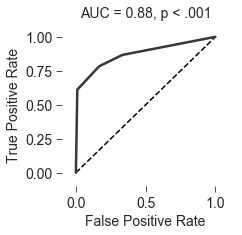

In [30]:
plot_roc(base_fold_roc, display_cv_folds=False, p_auc=p_auc)

In [31]:
clf = LDA(n_components=1)
X = np.array(all_joints_a_flat + all_joints_b_flat)
y = ["Angry"] * len(all_joints_a_flat) + ["Sad"] * len(all_joints_b_flat)
fit_sc = clf.fit(X, y).transform(X)
whole_body_lda_reduce_score_sc = clf.score(X,y)
whole_body_lda_reduce_score_sc

0.98333333333333328

In [32]:
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
np.mean(scores)

0.875

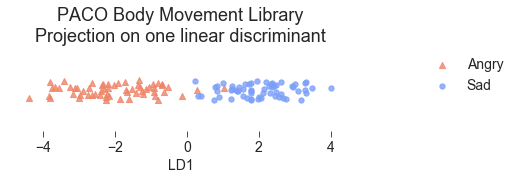

In [33]:
sns.set_style("ticks")
my_blue = sns.color_palette("coolwarm", 4)[0]
my_red = sns.color_palette("coolwarm", 4)[3]
fsize = 14

num_angry = len(all_joints_a_flat)
num_sad   = len(all_joints_b_flat)

jitter1 = np.random.rand(num_angry) - 0.5
jitter2 = np.random.rand(num_sad) - 0.5


plt.figure()
fig = plt.figure(figsize=(6,1.5))
ax = plt.gca()
#plt.scatter(np.repeat(1,num_angry) * jitter1, fit[0:num_angry, 0], color=sns.xkcd_rgb['golden yellow'], s=40, label="Angry")
#plt.scatter(np.repeat(1,num_sad) * jitter2, fit[num_angry:num_angry + num_sad, 0], color=sns.xkcd_rgb['windows blue'], s=40, label="Sad")

plt.scatter(fit_sc[0:num_angry, 0], np.repeat(1,num_angry) * jitter1, color=my_red, marker='^', s=37, alpha=0.8, label="Angry")
plt.scatter(fit_sc[num_angry:num_angry + num_sad, 0], np.repeat(1,num_sad) * jitter2, color=my_blue, s=28, alpha=0.8, label="Sad")

plt.legend(bbox_to_anchor=(1.2, 1.06), fontsize=fsize)
plt.ylim([-2, 2])
plt.tick_params(labelsize=fsize)
ax.set_xlabel("LD1", fontsize=fsize)
ax.axes.get_yaxis().set_visible(False)

plt.title('PACO Body Movement Library\nProjection on one linear discriminant', fontsize=18, y=1.03)

sns.despine(left=True, bottom=True)

In [34]:
def classify_LDA_dim_reduce(mean_scs_a, mean_scs_b, dim=1, permutation_test=False):
    clf = LDA(n_components=dim) 
    X = np.array(mean_scs_a + mean_scs_b)
    y = ["A"] * len(mean_scs_a) + ["B"] * len(mean_scs_b)
    if(permutation_test):
        random.shuffle(y)
    fit = clf.fit(X, y).transform(X)
    s = clf.score(X,y)
    return(s)

In [35]:
np.array(all_joints_a_flat).shape

(60, 45)

In [36]:
# p-values using scikit-learn permutation tests:
def classify_LDA_dim_reduce_permutation_test(mean_scs_a, mean_scs_b, dim=1):
    clf = LDA(n_components=dim)
    X = np.array(mean_scs_a + mean_scs_b)
    y = np.array(["A"] * len(mean_scs_a) + ["B"] * len(mean_scs_b))
    out = cross_validation.permutation_test_score(clf, X, y, scoring="accuracy", n_permutations=2000, cv=10)
    return(out)

In [37]:
acc, res, p = classify_LDA_dim_reduce_permutation_test(all_joints_a_flat, all_joints_b_flat)
print("Accuracy: {0}, p = {1}".format(acc, p))

Accuracy: 0.875, p = 0.000499750124938
